In [1]:
import anndata
import scanpy as sc
from pandas import read_csv
from scanpy_helpers.integration import normalize_by_gene_length

In [2]:
filters = read_csv('samplesheet_scrnaseq_preprocessing2.csv')

dataset_str = 'Leader_Merad_2021_10x_5p_v1_beads'

id_row = filters[filters.id == dataset_str]
file_str = id_row.input_adata.iloc[0].split('/')[-1]

In [3]:
thresholds = {}
thresholds['min_counts']  = int(id_row.min_counts)
thresholds['max_counts'] = int(id_row.max_counts)
thresholds['min_genes'] = int(id_row.min_genes)
thresholds['max_genes'] = int(id_row.max_genes)
thresholds['max_pct_mito'] = int(id_row.max_pct_mito)

adata = anndata.read_h5ad(f'/root/datos/maestria/netopaas/luca/data/12_input_adatas/{file_str}')

In [4]:
adata.obs.uicc_stage

AAACCTGAGAGTCTGG-1-0    II
AAACCTGAGATGCCAG-1-0    II
AAACCTGAGCTACCTA-1-0    II
AAACCTGAGTCTCCTC-1-0    II
AAACCTGAGTGCCATT-1-0    II
                        ..
TTTGTCAGTTCCATGA-1-1    II
TTTGTCATCAACGCTA-1-1    II
TTTGTCATCAATCACG-1-1    II
TTTGTCATCAGGCGAA-1-1    II
TTTGTCATCTCGTATT-1-1    II
Name: uicc_stage, Length: 11139, dtype: category
Categories (1, object): ['II']

In [5]:
# very basic gene filtering - genes with 0 cells cause some downstream processes to fail.
print("Filtering genes")
print(f"    Before: {adata.shape[1]}")
sc.pp.filter_genes(adata, min_counts=3)
print(f"    After: {adata.shape[1]}")

# %%
# Apply thresholds
print("Filter by min_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_counts=thresholds["min_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_counts=thresholds["max_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by min_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_genes=thresholds["min_genes"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_genes=thresholds["max_genes"])
print(f"    After: {adata.shape[0]}")

# %%
if "mito" not in adata.var.columns:
    adata.var["mito"] = adata.var_names.str.lower().str.startswith("mt-")

# %%
sc.pp.calculate_qc_metrics(
    adata, qc_vars=("mito",), log1p=False, inplace=True, percent_top=None
)

print("Filter by max_pct_mito")
print(f"    Before: {adata.shape[0]}")
adata = adata[adata.obs["pct_counts_mito"] < thresholds["max_pct_mito"]].copy()
print(f"    After: {adata.shape[0]}")

Filtering genes
    Before: 33694
    After: 21098
Filter by min_counts
    Before: 11139
    After: 8782
Filter by max_counts
    Before: 8782
    After: 8635
Filter by min_genes
    Before: 8635
    After: 8573
Filter by max_genes
    Before: 8573
    After: 8573
Filter by max_pct_mito
    Before: 8573
    After: 8529


/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


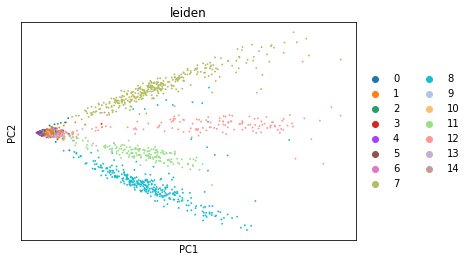

In [6]:
# Normalize the counts to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# Logarithmize the data
sc.pp.log1p(adata)

# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.3)
# Visualize the PCA result
sc.pl.pca(adata, color='leiden')

In [7]:
adata.write_h5ad(f'/root/datos/maestria/netopaas/luca/data/pcas/{file_str}')